## Import libraries

In [30]:
import numpy as np
import tensorflow as tf
import pandas as pd
import statistics
import cv2
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from torchvision import transforms
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Dropout, Flatten
from PIL import Image


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Import data sets**

In [22]:
csv_path_train = '/content/drive/MyDrive/mashrooms-vision/train.csv'
csv_path_test = '/content/drive/MyDrive/mashrooms-vision/test.csv'

images_folder = '/content/drive/MyDrive/mashrooms-vision/dataset/dataset'
sorted_folder = '/content/drive/MyDrive/mashrooms-vision/sorted/'
resized_folder = '/content/drive/MyDrive/mashrooms-vision/resized'

IMG_SIZE = 224

In [11]:
train_data = pd.read_csv(csv_path_train)
test_data = pd.read_csv(csv_path_test)

In [23]:
os.makedirs(sorted_folder, exist_ok=True)
os.makedirs(resized_folder, exist_ok=True)

In [8]:
train_data

Image  Mushroom
0         1         0
1         2         0
2         3         0
3         4         0
4         5         0
...     ...       ...
2360   2367         9
2361   2368         9
2362   2369         9
2363   2370         9
2364   2371         9

[2365 rows x 2 columns]

In [ ]:
test_data

Image
0     2372
1     2373
2     2374
3     2375
4     2376
..     ...
593   2967
594   2968
595   2969
596   2970
597   2971

[598 rows x 1 columns]

### **Sort images by class**

In [ ]:
for _, row in train_data.iterrows():
    image_name = str(row['Image']).zfill(5) + '.jpg'
    label = str(row['Mushroom'])

    src = os.path.join(images_folder, image_name)
    dst_folder = os.path.join(sorted_folder, label)
    dst = os.path.join(dst_folder, image_name)

    os.makedirs(dst_folder, exist_ok=True)

    if os.path.exists(src):
        shutil.copy(src, dst)
    else:
        print(f"not found: {src}")

## **Dataset Feature Description**

This dataset contains images of mushrooms, with the goal of classifying them into their respective types. Each entry represents one mushroom, described by the following features:

**ImageID:** The filename or identifier of the mushroom image.

**Mushroom:** The class or type of the mushroom (e.g., Agaricus, Amanita, etc.).

### **Check which mushroom classes are in the dataset and count images per class**

In [ ]:
class_order = sorted(train_data['Mushroom'].unique())
class_counts = train_data['Mushroom'].value_counts().reindex(class_order)
print("\nAmount images for each class:")
print(class_counts)


Amount images for each class:
Mushroom
0    238
1    240
2    240
3    222
4    227
5    240
6    238
7    240
8    240
9    240
Name: count, dtype: int64


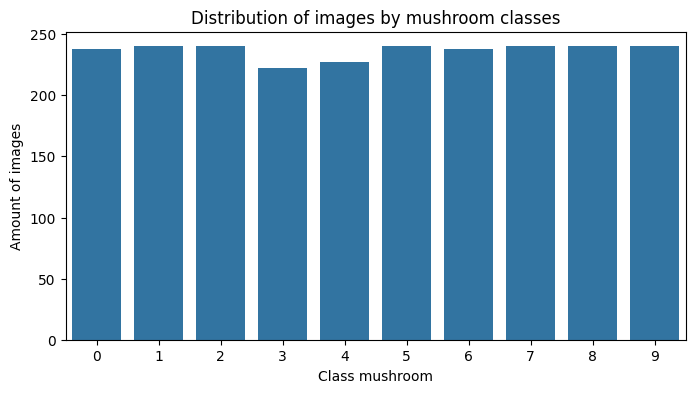

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(x='Mushroom', data=train_data, order=class_order)
plt.title("Distribution of images by mushroom classes")
plt.xlabel("Class mushroom")
plt.ylabel("Amount of images")
plt.show()

###**Check for missing values**

In [ ]:
print(train_data.isnull().sum())

Image       0
Mushroom    0
dtype: int64


<Axes: >

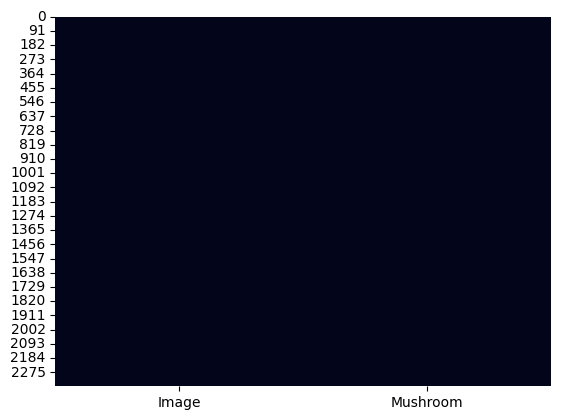

In [ ]:
sns.heatmap(train_data.isnull(), cbar=False)

*No missing values in train_data*

In [ ]:
print(test_data.isnull().sum())

Image    0
dtype: int64


<Axes: >

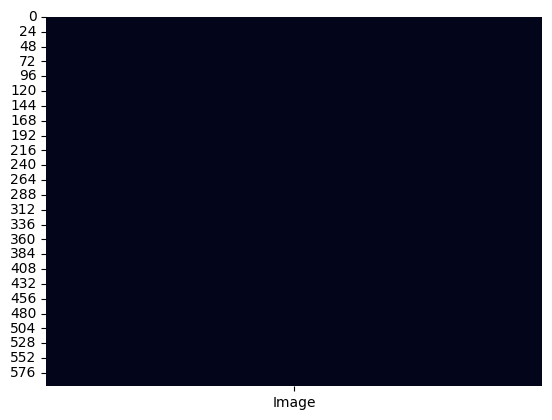

In [ ]:
sns.heatmap(test_data.isnull(), cbar=False)

*No missing values in test_data*

### **Check The Duplicates**

In [ ]:
train_data.duplicated().sum()

np.int64(0)

In [ ]:
test_data.duplicated().sum()

np.int64(0)

*There are no duplicates*

### **Main info about dataset**

In [ ]:
train_data.shape

(2365, 2)

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2365 entries, 0 to 2364
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Image     2365 non-null   int64
 1   Mushroom  2365 non-null   int64
dtypes: int64(2)
memory usage: 37.1 KB


In [ ]:
train_data.describe()

Image     Mushroom
count  2365.000000  2365.000000
mean   1186.930655     4.516702
std     684.671948     2.887527
min       1.000000     0.000000
25%     594.000000     2.000000
50%    1187.000000     5.000000
75%    1780.000000     7.000000
max    2371.000000     9.000000

## **Inspect image properties**

### **Image resolution statistics**

In [ ]:
widths, heights = [], []
for img_file in os.listdir(images_folder):
    if img_file.endswith('.jpg'):
        img_path = os.path.join(images_folder, img_file)
        img = Image.open(img_path)
        w, h = img.size
        widths.append(w)
        heights.append(h)

print(f"Min resolution: {min(widths)}x{min(heights)}")
print(f"Max resolution: {max(widths)}x{max(heights)}")

Min resolution: 142x112
Max resolution: 1640x1096


### **Width distribution analysis**

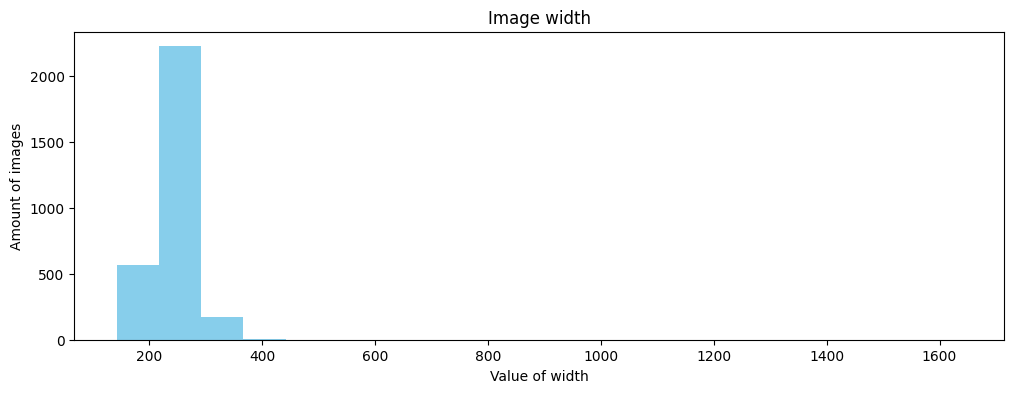

In [ ]:
plt.figure(figsize=(12,4))
plt.hist(widths, bins=20, color='skyblue')
plt.title("Image width")
plt.xlabel("Value of width")
plt.ylabel("Amount of images")

plt.show()

In [ ]:
print("Most common width:", statistics.mode(widths))

Most common width: 259


### **Height distribution analysis**

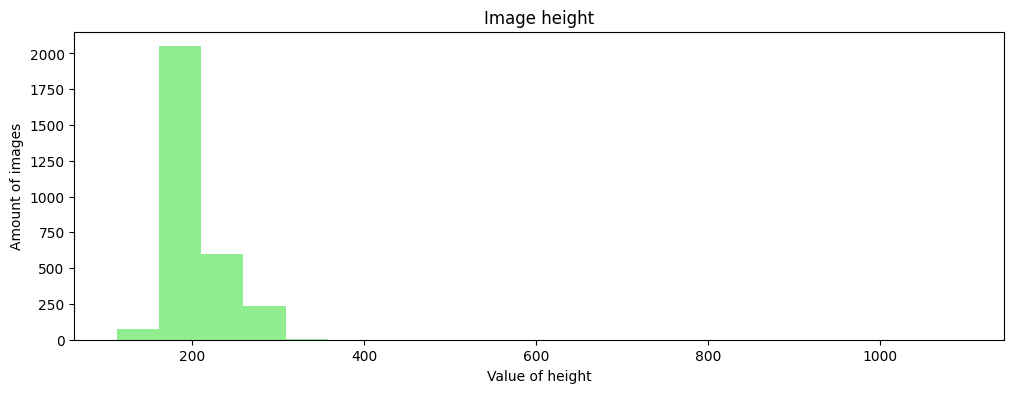

In [ ]:
plt.figure(figsize=(12,4))
plt.hist(heights, bins=20, color='lightgreen')
plt.title("Image height")
plt.xlabel("Value of height")
plt.ylabel("Amount of images")

plt.show()

In [ ]:
print("Most common height:", statistics.mode(heights))

Most common height: 183


### **Collecting sample images and their properties**

In [ ]:
sample_images = []

for class_name in os.listdir(sorted_folder):
    class_path = os.path.join(sorted_folder, class_name)
    for img_name in os.listdir(class_path):
        sample_images.append(os.path.join(class_path, img_name))
        break

for img_path in sample_images:
    img = cv2.imread(img_path)
    h, w, c = img.shape
    size_kb = os.path.getsize(img_path) / 1024

    print(f"Image path: {img_path}")
    print(f" - Resolution: {w}x{h}")
    print(f" - Channels: {c}")
    print(f" - File size: {size_kb:.2f} KB\n")


Image: /content/drive/MyDrive/mashrooms-vision/sorted/0/00001.jpg
 - Resolution: 188x268
 - Channels: 3
 - File size: 4.66 KB

Image: /content/drive/MyDrive/mashrooms-vision/sorted/1/00241.jpg
 - Resolution: 259x194
 - Channels: 3
 - File size: 13.61 KB

Image: /content/drive/MyDrive/mashrooms-vision/sorted/2/00481.jpg
 - Resolution: 225x225
 - Channels: 3
 - File size: 11.64 KB

Image: /content/drive/MyDrive/mashrooms-vision/sorted/3/00721.jpg
 - Resolution: 239x211
 - Channels: 3
 - File size: 5.72 KB

Image: /content/drive/MyDrive/mashrooms-vision/sorted/4/00945.jpg
 - Resolution: 275x183
 - Channels: 3
 - File size: 13.19 KB

Image: /content/drive/MyDrive/mashrooms-vision/sorted/5/01172.jpg
 - Resolution: 248x203
 - Channels: 3
 - File size: 13.07 KB

Image: /content/drive/MyDrive/mashrooms-vision/sorted/6/01412.jpg
 - Resolution: 300x168
 - Channels: 3
 - File size: 11.51 KB

Image: /content/drive/MyDrive/mashrooms-vision/sorted/7/01652.jpg
 - Resolution: 268x188
 - Channels: 3
 -

### **Visualizing one sample image per class**

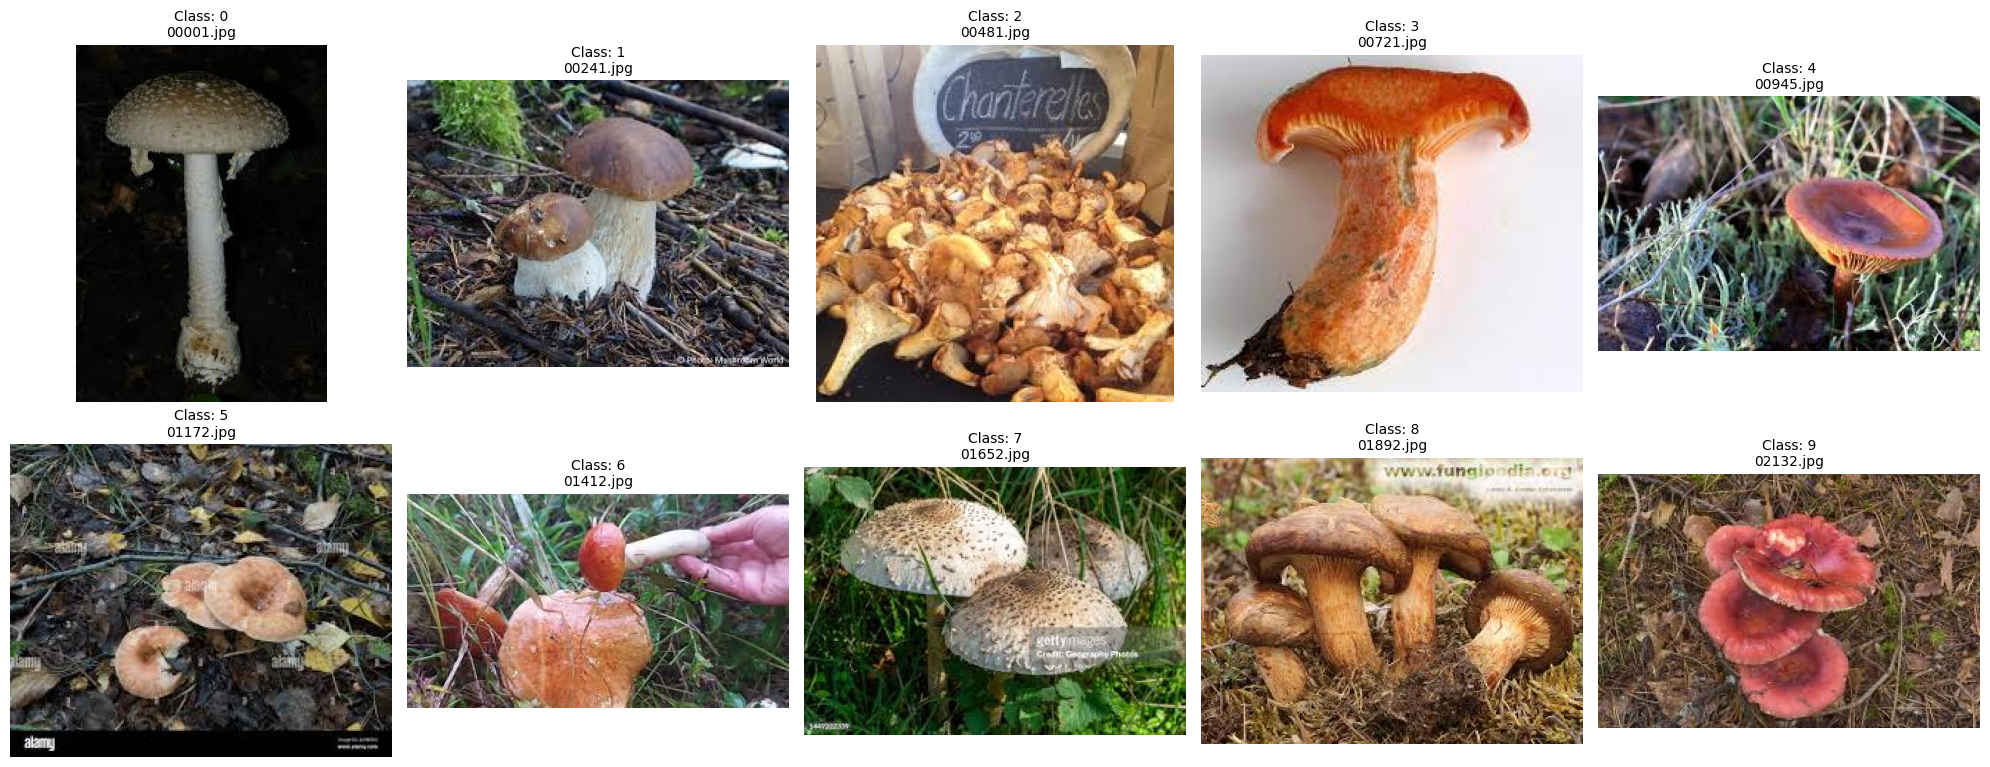

In [ ]:
plt.figure(figsize=(20, 8))
for i, img_path in enumerate(sample_images):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    class_name = img_path.split("/")[-2]
    file_name = img_path.split("/")[-1]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Class: {class_name}\n{file_name}", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()


### **Image resizing**



*Resize with folder separation by class*

In [25]:
for class_name in os.listdir(sorted_folder):
    class_input_path = os.path.join(sorted_folder, class_name)
    class_output_path = os.path.join(resized_folder, class_name)

    if not os.path.exists(class_output_path):
        os.makedirs(class_output_path, exist_ok=True)

    os.makedirs(class_output_path, exist_ok=True)

    for img_file in tqdm(os.listdir(class_input_path), desc=f"Class {class_name}"):
        if not img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        src = os.path.join(class_input_path, img_file)
        dst = os.path.join(class_output_path, img_file)

        if os.path.exists(dst):
            continue

        img = cv2.imread(src)
        if img is None:
            print("Bad image:", img_file)
            continue

        img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        cv2.imwrite(dst, img_resized)

print("\n✔ All images resized and sorted successfully!")

Class 9: 100%|██████████| 240/240 [00:00<00:00, 3811.68it/s]


✔ All images resized and sorted successfully!


In [27]:
widths, heights = [], []

for class_name in os.listdir(resized_folder):
    class_path = os.path.join(resized_folder, class_name)
    if not os.path.isdir(class_path):
        continue

    for img_file in os.listdir(class_path):
        if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(class_path, img_file)
            img = Image.open(img_path)
            w, h = img.size
            widths.append(w)
            heights.append(h)

print(f"Min resolution: {min(widths)}x{min(heights)}")
print(f"Max resolution: {max(widths)}x{max(heights)}")

Min resolution: 224x224
Max resolution: 224x224


*Resolution is the same on each foto*

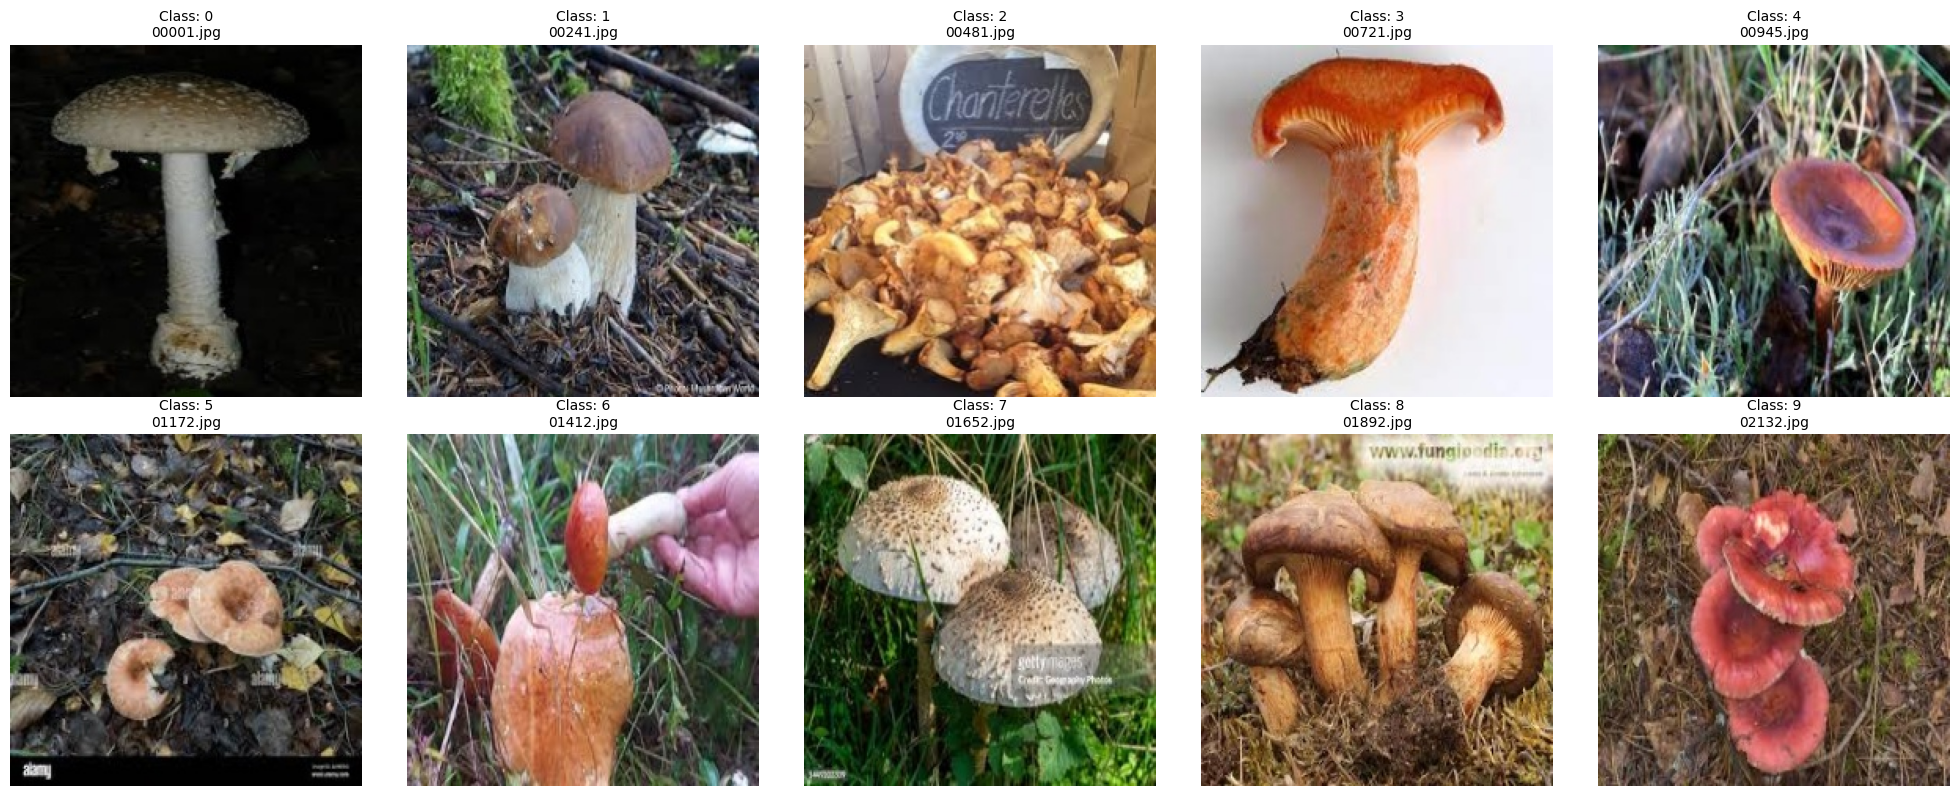

In [29]:
sample_images = []

for class_name in os.listdir(resized_folder):
    class_path = os.path.join(resized_folder, class_name)
    for img_name in sorted(os.listdir(class_path)):  # <--- сортуємо
        sample_images.append(os.path.join(class_path, img_name))
        break

plt.figure(figsize=(20, 8))
for i, img_path in enumerate(sample_images):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    class_name = img_path.split("/")[-2]
    file_name = img_path.split("/")[-1]

    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Class: {class_name}\n{file_name}", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()

### **Normalization**

In [31]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

### **Data Augmentation**

In [33]:
train_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2)
])

### **Together**

In [ ]:
train_transform = transforms.Compose([
    train_augmentation,
    train_transform
])